# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

# Train on a custom dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [4]:
balloon_metadata

namespace(name='balloon_train', thing_classes=['balloon'])

To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:



In [5]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances('coco_trash_train', {}, '../../../dataset/train.json', '../../../dataset/')
# register_coco_instances('coco_trash_test', {}, '../../../dataset/test.json', '../../../dataset/')

# MetadataCatalog.get('coco_trash_train').thing_classes = ["General trash", "Paper", "Paper pack", "Metal", 
#                                                          "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

In [6]:
dataset_dicts = get_balloon_dicts("balloon/train")

In [11]:
dataset_dicts

[{'file_name': 'balloon/train/34020010494_e5cb88e1c4_k.jpg',
  'image_id': 0,
  'height': 1536,
  'width': 2048,
  'annotations': [{'bbox': [994, 619, 1445, 1166],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'segmentation': [[1020.5,
      963.5,
      1000.5,
      899.5,
      994.5,
      841.5,
      1003.5,
      787.5,
      1023.5,
      738.5,
      1050.5,
      700.5,
      1089.5,
      663.5,
      1134.5,
      638.5,
      1190.5,
      621.5,
      1265.5,
      619.5,
      1321.5,
      643.5,
      1361.5,
      672.5,
      1403.5,
      720.5,
      1428.5,
      765.5,
      1442.5,
      800.5,
      1445.5,
      860.5,
      1441.5,
      896.5,
      1427.5,
      942.5,
      1400.5,
      990.5,
      1361.5,
      1035.5,
      1316.5,
      1079.5,
      1269.5,
      1112.5,
      1228.5,
      1129.5,
      1198.5,
      1134.5,
      1207.5,
      1144.5,
      1210.5,
      1153.5,
      1190.5,
      1166.5,
      1177.5,
      1166.5,
      1172.5,
  

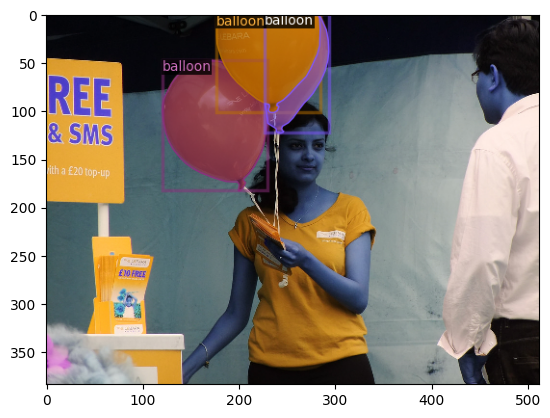

In [12]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    print(visualizer)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/09 13:38:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/09 13:38:33 d2.engine.train_loop]: Starting training from iteration 0


/data/ephemeral/home/level2-objectdetection-cv-10/develop/StringZero/detectron2/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/data/ephemeral/home/level2-objectdetection-cv-10/develop/StringZero/detectron2/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/data/ephemeral/home/level2-objectdetection-cv-10/develop/StringZero/detectron2/detectron2/structures/image_

[01/09 13:38:39 d2.utils.events]:  eta: 0:00:47  iter: 19  total_loss: 1.94  loss_cls: 0.611  loss_box_reg: 0.5772  loss_mask: 0.686  loss_rpn_cls: 0.02498  loss_rpn_loc: 0.005049  time: 0.1726  data_time: 0.0236  lr: 1.6068e-05  max_mem: 2544M
[01/09 13:38:43 d2.utils.events]:  eta: 0:00:45  iter: 39  total_loss: 1.874  loss_cls: 0.5461  loss_box_reg: 0.7134  loss_mask: 0.5895  loss_rpn_cls: 0.02217  loss_rpn_loc: 0.0097  time: 0.1750  data_time: 0.0101  lr: 3.2718e-05  max_mem: 2544M
[01/09 13:38:46 d2.utils.events]:  eta: 0:00:42  iter: 59  total_loss: 1.613  loss_cls: 0.4453  loss_box_reg: 0.6162  loss_mask: 0.4934  loss_rpn_cls: 0.04716  loss_rpn_loc: 0.008433  time: 0.1756  data_time: 0.0068  lr: 4.9367e-05  max_mem: 2544M
[01/09 13:38:50 d2.utils.events]:  eta: 0:00:38  iter: 79  total_loss: 1.474  loss_cls: 0.3792  loss_box_reg: 0.6892  loss_mask: 0.3747  loss_rpn_cls: 0.02259  loss_rpn_loc: 0.008026  time: 0.1755  data_time: 0.0073  lr: 6.6017e-05  max_mem: 2544M
[01/09 13:38:

In [17]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [9]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

/data/ephemeral/home/level2-objectdetection-cv-10/develop/StringZero/detectron2/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


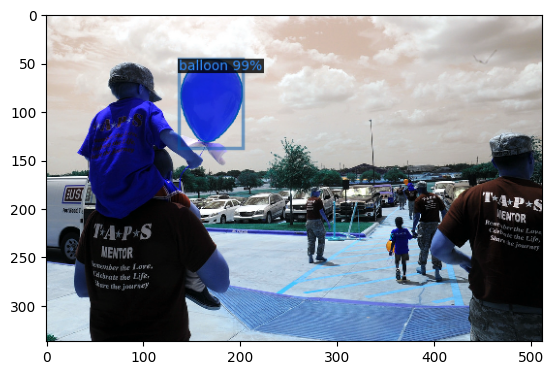

In [10]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[01/09 13:39:35 d2.evaluation.coco_evaluation]: 'balloon_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [01/09 13:39:35 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/balloon_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[01/09 13:39:36 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[01/09 13:39:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/09 13:39:36 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[01/09 13:39:36 d2.data.common]: Serialized dataset takes 0.04 MiB
[01/09 13:39:36 d2.evaluation.evaluator]: Start inference on 13 batches
[01/09 1

# Other types of builtin models

We showcase simple demos of other types of models below:

In [12]:
# # Inference with a panoptic segmentation model
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
# predictor = DefaultPredictor(cfg)
# panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# plt.imshow(out.get_image()[:, :, ::-1])

# Run panoptic segmentation on a video

In [13]:
# # This is the video we're going to process
# from IPython.display import YouTubeVideo, display
# video = YouTubeVideo("ll8TgCZ0plk", width=500)
# display(video)

In [14]:
# # Install dependencies, download the video, and crop 5 seconds for processing
# !pip install youtube-dl
# !youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
# !ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [15]:
# # Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
# !git clone https://github.com/facebookresearch/detectron2
# # Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
# %run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
#   --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [16]:
# # Download the results
# from google.colab import files
# files.download('video-output.mkv')